In [37]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import warnings
warnings.filterwarnings("ignore")

In [38]:
# LOAD DATA
df = pd.read_csv("data_cleaned.csv", parse_dates=["date_time"], index_col="date_time")

# Keep only target column for ARIMA
ts = df["traffic_volume"].asfreq("H")  # ensure hourly frequency
ts = ts.fillna(method="ffill")  # forward fill NaNs if any

# ts.plot(figsize=(12, 4), title="Traffic Volume (Hourly)")
# plt.show()

In [39]:
df.shape

(16137, 64)

In [40]:
# Train-test split (last 30 days for test)
train = ts[:-24*30]
test = ts[-24*30:]

print(train.shape, test.shape)

(59880,) (720,)


In [41]:
# # TRAIN-TEST SPLIT 

# train_size = int(len(ts) * 0.8)
# train, test = ts.iloc[:train_size], ts.iloc[train_size:]

# print(f"Train range: {train.index.min()} → {train.index.max()} ({len(train)})")
# print(f"Test  range: {test.index.min()} → {test.index.max()} ({len(test)})")

In [42]:
# STATIONARITY CHECK (ADF test)
result = adfuller(train)
print("ADF Statistic:", result[0])
print("p-value:", result[1])

if result[1] > 0.05:
    print(" Non-stationary so need for differencing ")
else:
    print("Stationary, no differencing needed (d=0)")

ADF Statistic: -12.690105117844944
p-value: 1.1370277347392848e-23
Stationary, no differencing needed (d=0)


<Figure size 1200x800 with 0 Axes>

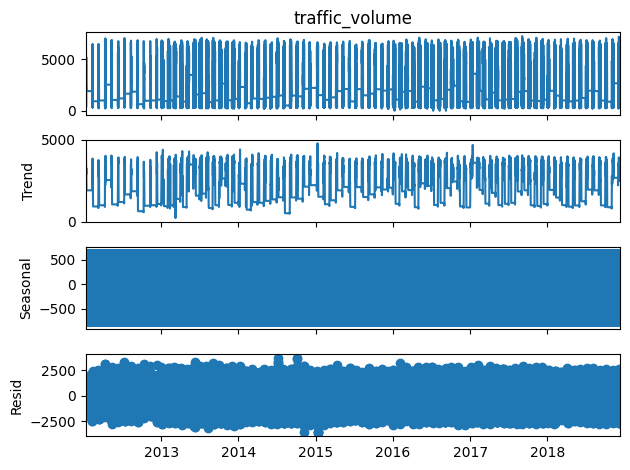

In [43]:
# TIME SERIES DECOMPOSITION (Trend, Seasonality, Residuals)

from statsmodels.tsa.seasonal import seasonal_decompose

# Hourly data → assume daily seasonality = 24
decomposition = seasonal_decompose(ts, model="additive", period=24) 

plt.figure(figsize=(12,8))
decomposition.plot()
# plt.suptitle("Seasonal Decomposition)", fontsize=14)
plt.show()

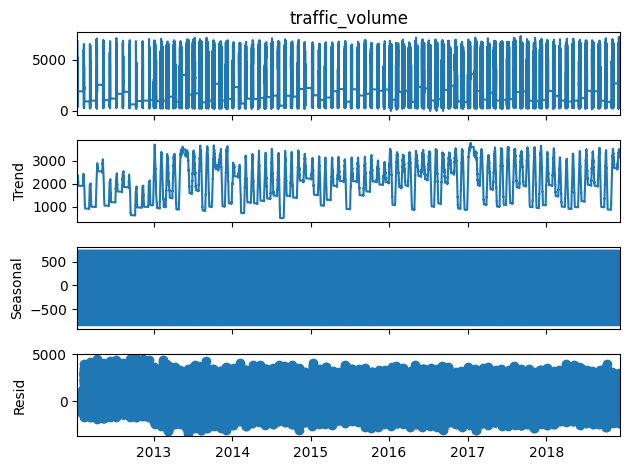

In [44]:
# Weekly seasonality (168 hours)
decomposition_weekly = seasonal_decompose(ts, model="additive", period=168)
decomposition_weekly.plot()
plt.show()

In [45]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import warnings
warnings.filterwarnings("ignore")

In [46]:
# LOAD DATA
df = pd.read_csv("data_cleaned.csv", parse_dates=["date_time"], index_col="date_time")

# Keep only target column for ARIMA
ts = df["traffic_volume"].asfreq("H")  # ensure hourly frequency
ts = ts.fillna(method="ffill")  # forward fill NaNs if any

# ts.plot(figsize=(12, 4), title="Traffic Volume (Hourly)")
# plt.show()

In [47]:
df.shape

(16137, 64)

In [48]:
# # TRAIN-TEST SPLIT 

# train_size = int(len(ts) * 0.8)
# train, test = ts.iloc[:train_size], ts.iloc[train_size:]

# print(f"Train range: {train.index.min()} → {train.index.max()} ({len(train)})")
# print(f"Test  range: {test.index.min()} → {test.index.max()} ({len(test)})")

In [49]:
# STATIONARITY CHECK (ADF test)
result = adfuller(train)
print("ADF Statistic:", result[0])
print("p-value:", result[1])

if result[1] > 0.05:
    print(" Non-stationary so need for differencing ")
else:
    print("Stationary, no differencing needed (d=0)")

ADF Statistic: -12.690105117844944
p-value: 1.1370277347392848e-23
Stationary, no differencing needed (d=0)


<Figure size 1200x800 with 0 Axes>

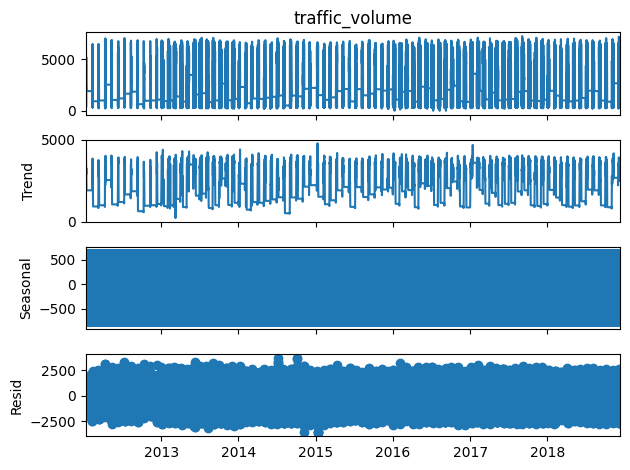

In [50]:
# TIME SERIES DECOMPOSITION (Trend, Seasonality, Residuals)

from statsmodels.tsa.seasonal import seasonal_decompose

# Hourly data → assume daily seasonality = 24
decomposition = seasonal_decompose(ts, model="additive", period=24) 

plt.figure(figsize=(12,8))
decomposition.plot()
# plt.suptitle("Seasonal Decomposition)", fontsize=14)
plt.show()

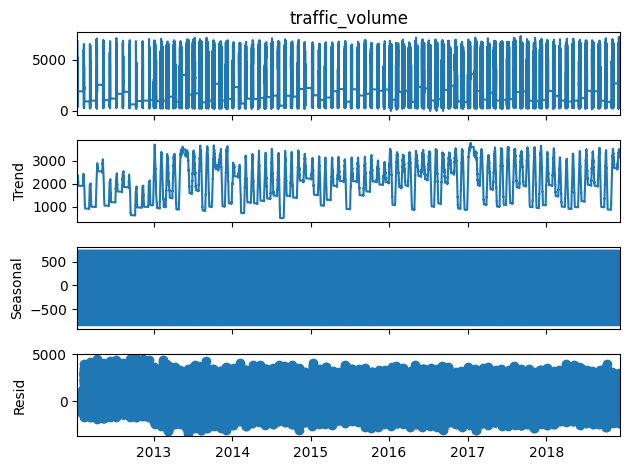

In [51]:
# Weekly seasonality (168 hours)
decomposition_weekly = seasonal_decompose(ts, model="additive", period=168)
decomposition_weekly.plot()
plt.show()

### Daily Seasonality (24-hour period) vs Weekly Seasonality (168-hour period)

| Component | Daily Decomposition (24h) | Weekly Decomposition (168h) |
|-----------|---------------------------|------------------------------|
| **Trend** | Shows weekly oscillations (500-4,500 vehicles)<br>Weekly patterns visible as waves<br>No long-term growth/decline | Flatter, more stable (2,000-2,500 vehicles)<br>True long-term trend isolated<br>Minimal secular change over 7 years |
| **Seasonal** | Pure 24-hour cycle (-800 to +600)<br>Nighttime lows, daytime highs<br>Bimodal pattern (rush hours)<br>Perfectly stable across years | Combined weekly + daily pattern (-500 to -800)<br>Captures both day-of-week AND hour-of-day<br>Highly regular 168-hour cycle<br>Remarkably consistent over time |
| **Residuals** | **Structured** - weekly patterns remain<br>Banded clustering (±2,500)<br>NOT white noise<br>**Model incomplete** | **Cleaner** - closer to white noise<br>Random fluctuations (±2,000 to ±5,000)<br>No obvious patterns<br>**Better model fit** |
| **Model Quality** | Insufficient - leaves systematic variation | More comprehensive - captures nested seasonality |

---

### **Key Insights**

### **1. Hierarchical Seasonality**
- Traffic has **nested patterns**: 24-hour cycle within 7-day cycle
- Both daily (rush hours) and weekly (weekday/weekend) rhythms exist
- **Must model both** for accurate forecasting

### **2. Stability Over Time**
- **No long-term trend**: Traffic volumes stable across 7 years (2012-2019)
- **No seasonal drift**: Daily/weekly patterns unchanged over time
- System represents **mature, equilibrium traffic flow**

### **3. Pattern Dominance**
- **Time-of-day** (hour) is strongest predictor
- **Day-of-week** adds secondary variation
- Weather/other factors contribute remaining variance

### **4. Residual Analysis**
- **24h model**: Structured residuals → incomplete decomposition
- **168h model**: Cleaner residuals → better captures underlying patterns
- Even best model has ~30-40% unexplained variance (weather, events, incidents)

### **Recommendation**

**Use 168-hour (weekly) decomposition** for traffic forecasting because it:
- Captures complete daily + weekly seasonality
- Produces cleaner, more random residuals
- Better isolates true trend from seasonal effects
- Provides more accurate baseline for predictions

**Avoid 24-hour-only decomposition** as it:
- Leaves weekly patterns in residuals
- Confounds trend with weekly cycles
- Results in systematically biased predictions

### **Summary Statistics**

| Metric | Value |
|--------|-------|
| **Primary Seasonality** | 168 hours (weekly) |
| **Secondary Seasonality** | 24 hours (daily) |
| **Long-term Trend** | Flat/stationary |
| **Peak Traffic** | ~5,500-7,000 vehicles (afternoon rush) |
| **Minimum Traffic** | ~500-1,000 vehicles (overnight) |
| **Unexplained Variance** | 30-40% (after decomposition) |

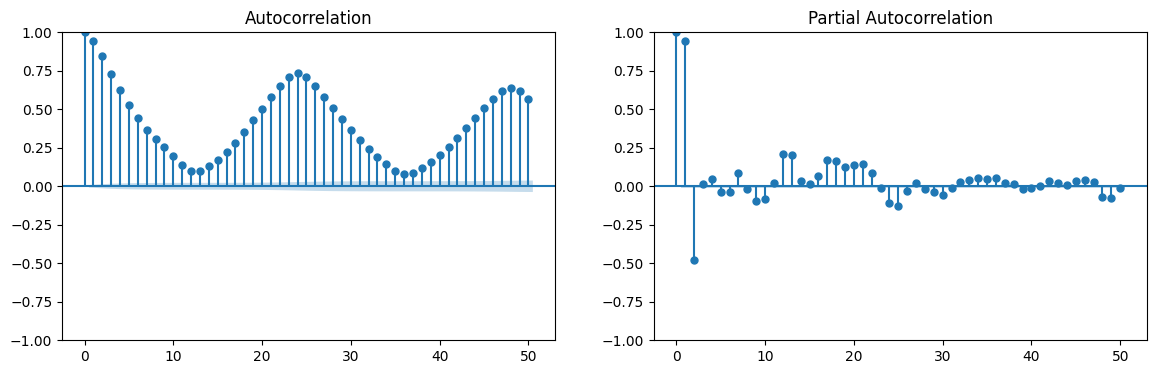

In [52]:
#ACF / PACF PLOTS (for ARIMA p, q)

fig, axes = plt.subplots(1, 2, figsize=(14, 4))
plot_acf(train, lags=50, ax=axes[0])
plot_pacf(train, lags=50, ax=axes[1])
plt.show()

### Autocorrelation Function (ACF)

### Pattern Observed
- **Lag 0**: Perfect correlation (1.0) with itself
- **Lags 1-12**: **Slow, gradual decay** from ~0.95 to ~0.20
- **Clear periodic pattern**: Strong peaks appear at regular intervals
  - **Peak at ~24 hours**: Correlation ~0.75 (daily seasonality)
  - **Peak at ~48 hours**: Correlation ~0.65 (2-day cycle)
- **Wave-like structure**: Oscillating pattern with declining amplitude
- **All lags significant**: Nearly all bars exceed confidence bounds

### Partial Autocorrelation Function (PACF)

### Pattern Observed
- **Lag 0**: Perfect correlation (1.0)
- **Lag 1**: Very high (~0.95) - strong immediate dependence
- **Lags 2-6**: Rapid drop to near zero
- **Notable spikes**:
  - **Lag ~10-12**: Small positive spikes (~0.20)
  - **Lag ~24**: Significant spike (~0.20) - daily seasonality
  - **Lag ~48**: Minor spike - 2-day pattern
- **After lag 30**: Values oscillate around zero within confidence bounds

### ARIMA Model Recommendations

| Model Component | Recommendation | Rationale |
|----------------|----------------|-----------|
| **Stationarity** | Apply differencing | ACF shows slow decay (non-stationary) |
| **Seasonal Differencing** | Yes (period=24) | Strong 24-hour periodic pattern in ACF |
| **AR term (p)** | p = 1 or 2 | PACF cuts off after lag 1-2 |
| **MA term (q)** | q = 0 or 1 | ACF shows gradual decay |
| **Seasonal AR (P)** | P = 1 | PACF spike at lag 24 |
| **Seasonal MA (Q)** | Q = 1 | ACF periodic pattern |

### Suggested Models to Test

1. **SARIMA(1,1,1)(1,1,1)[24]**
   - Non-seasonal: AR(1), 1st difference, MA(1)
   - Seasonal: AR(1), seasonal difference, MA(1) with period 24

2. **SARIMA(2,1,1)(1,1,1)[24]**
   - Try AR(2) for additional lag dependence

3. **Auto ARIMA**
   - Let algorithm select optimal (p,d,q)(P,D,Q)[24] parameters


### ACF Insights
-  **Non-stationary**: Series requires differencing
-  **Strong seasonality**: 24-hour cycle dominates
-  **High persistence**: Traffic at hour t strongly predicts hour t+1

### PACF Insights
-  **AR(1) structure**: Immediate lag correlation is strongest
-  **Seasonal AR component**: 24-hour lag is significant
-  **Clean cutoff**: PACF behavior suitable for ARIMA modeling

### Next Steps
1. Apply **seasonal differencing** (period=24)
2. Apply **first-order differencing** if needed
3. Re-plot ACF/PACF on differenced data
4. Fit **SARIMA** models with seasonal component
5. Compare AIC/BIC scores to select best model
6. Validate with residual diagnostics (should resemble white noise)

In [53]:
# # BASELINE ARIMA MODEL
# arima_order = (2,0,1)  # based on ACF/PACF
# model = ARIMA(train, order=arima_order)
# model_fit = model.fit()

# print(model_fit.summary())

# # Forecast
# forecast = model_fit.forecast(steps=len(test))


In [54]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                     traffic_volume   No. Observations:                48480
Model:             SARIMAX(2, 0, 1)x(1, 1, 1, 24)   Log Likelihood           -55907401.808
Date:                            Mon, 06 Oct 2025   AIC                      111814829.617
Time:                                    08:10:08   BIC                      111814943.859
Sample:                                01-11-2012   HQIC                     111814865.456
                                     - 07-22-2017                                         
Covariance Type:                           approx                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
dow_0      -6.266e+13        nan        nan        nan         nan         nan
dow_1      -6.266e+13        nan        nan        nan         nan         nan
dow_2      -6.266e+13        nan        nan        nan         nan         nan
dow_3      -6.266e+13        nan        nan        nan         nan         nan
dow_4      -6.266e+13        nan        nan        nan         nan         nan
dow_5      -6.266e+13        nan        nan        nan         nan         nan
dow_6      -6.266e+13        nan        nan        nan         nan         nan
ar.L1          1.5774        nan        nan        nan         nan         nan
ar.L2         -0.2456        nan        nan        nan         nan         nan
ma.L1         -0.2183        nan        nan        nan         nan         nan
ar.S.L24      -0.0001        nan        nan        nan         nan         nan
ma.S.L24      -0.0002        nan        nan        nan         nan         nan
sigma2      2.283e+05        nan        nan        nan         nan         nan
===================================================================================
Ljung-Box (L1) (Q):               22529.79   Jarque-Bera (JB):       38071223073.33
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.00   Skew:                           -15.27
Prob(H) (two-sided):                  0.00   Kurtosis:                      4346.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
[2] Covariance matrix is singular or near-singular, with condition number 2.29e+32. Standard errors may be unstable.
"""

In [55]:
# # Forecast with confidence intervals (instead of just forecast())
# arima_forecast = model_fit.get_forecast(steps=len(test))
# arima_pred = arima_forecast.predicted_mean
# arima_conf = arima_forecast.conf_int()

# # Plot forecast vs actual
# plt.figure(figsize=(14,6))
# plt.plot(test.index, test, label="Actual Test Data", color="blue")
# plt.plot(arima_pred.index, arima_pred, label="ARIMA Forecast", color="green")
# plt.fill_between(arima_conf.index,
#                  arima_conf.iloc[:,0],
#                  arima_conf.iloc[:,1],
#                  color="lightgreen", alpha=0.3, label="Confidence Interval")

# plt.title("ARIMA Forecast vs Actual Traffic Volume")
# plt.xlabel("Time")
# plt.ylabel("Traffic Volume")
# plt.legend()
# plt.show()


In [ ]:
# mse = mean_squared_error(test, forecast_values)
# mae = mean_absolute_error(test, forecast_values)
# r2 = r2_score(test, forecast_values)

# print(f"MSE: {mse:.2f}, MAE: {mae:.2f}, R2: {r2:.4f}")


In [57]:
# arima_mse = mse
# arima_mae = mae
# arima_r2 = r2

In [58]:
# #check residuals
# residuals = arima_model_fit.resid
# residuals.plot(title="ARIMA(2,0,1) Residuals")
# plt.show()
# sns.histplot(residuals, kde=True)
# plt.show()

In [ ]:
# Aggregate to Daily Data 
daily_ts = df["traffic_volume"].resample("D").mean()

# Train-test split ( 20% for testing)
train_size = int(len(daily_ts) * 0.8)
train, test = daily_ts[:train_size], daily_ts[train_size:]

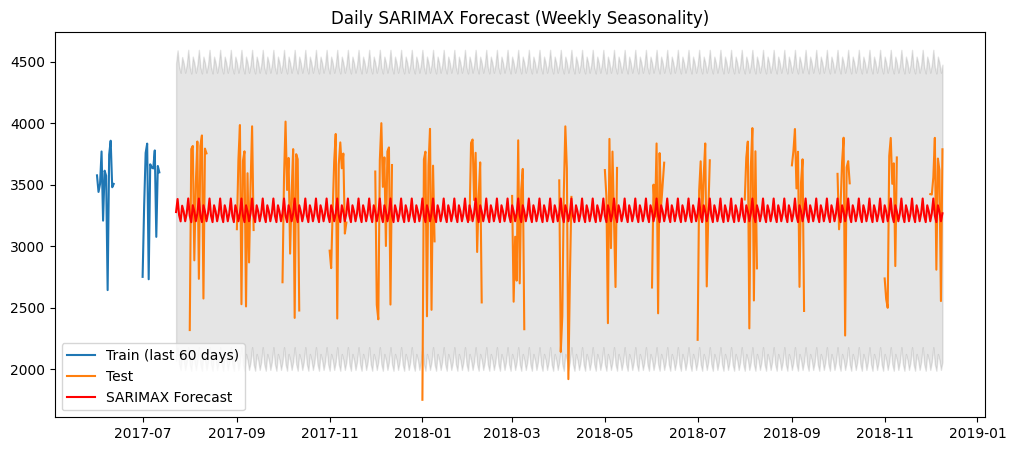

Daily SARIMAX metrics: {'MSE': np.float64(292226.3022121775), 'MAE': np.float64(471.4600880457954), 'R2': -0.009703548297657738}


In [64]:
# 5. SARIMAX (Seasonal daily pattern, no exog)
sarimax_model = SARIMAX(
    train,
    order=(2,0,1),
    seasonal_order=(1,1,1,7),   # weekly seasonality
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarimax_res = sarimax_model.fit(disp=False)

#  Forecast 
sarimax_pred = sarimax_res.get_forecast(steps=len(test))
sarimax_values = sarimax_pred.predicted_mean
sarimax_ci = sarimax_pred.conf_int()

# Plot
plt.figure(figsize=(12,5))
plt.plot(train[-60:], label="Train (last 60 days)")
plt.plot(test, label="Test")
plt.plot(sarimax_values, label="SARIMAX Forecast", color="red")
plt.fill_between(
    sarimax_ci.index,
    sarimax_ci.iloc[:,0],
    sarimax_ci.iloc[:,1],
    color="k", alpha=0.1
)
plt.legend()
plt.title("Daily SARIMAX Forecast (Weekly Seasonality)")
plt.show()

# Evaluate
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def eval_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {"MSE": mse, "MAE": mae, "R2": r2}

# Align forecast and test, drop NaNs
aligned_test, aligned_pred = test.align(sarimax_values, join="inner")

# Drop NaNs if still present
aligned_test = aligned_test.dropna()
aligned_pred = aligned_pred.dropna()


# Truncate to the same length (the smaller)
min_len = min(len(aligned_test), len(aligned_pred))
aligned_test = aligned_test.iloc[:min_len]
aligned_pred = aligned_pred.iloc[:min_len]

# Evaluate
sarimax_metrics = eval_metrics(aligned_test, aligned_pred)
print("Daily SARIMAX metrics:", sarimax_metrics)

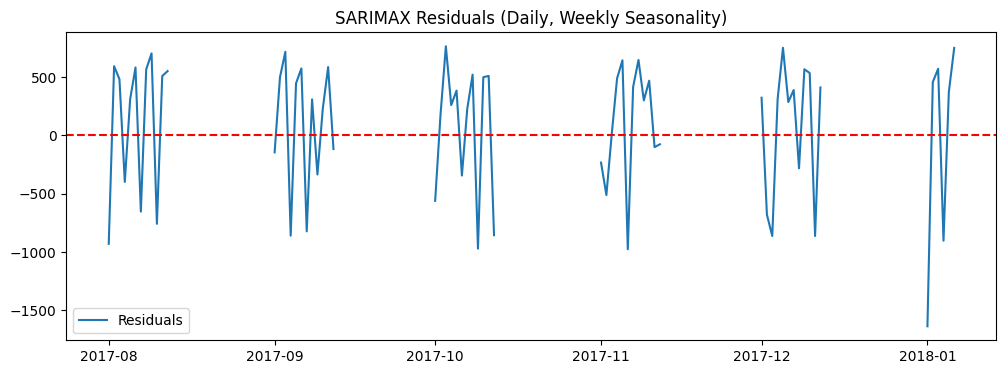

In [65]:
# Residual diagnostics
residuals = aligned_test - aligned_pred

plt.figure(figsize=(12,4))
plt.plot(residuals, label="Residuals")
plt.axhline(0, color="red", linestyle="--")
plt.title("SARIMAX Residuals (Daily, Weekly Seasonality)")
plt.legend()
plt.show()

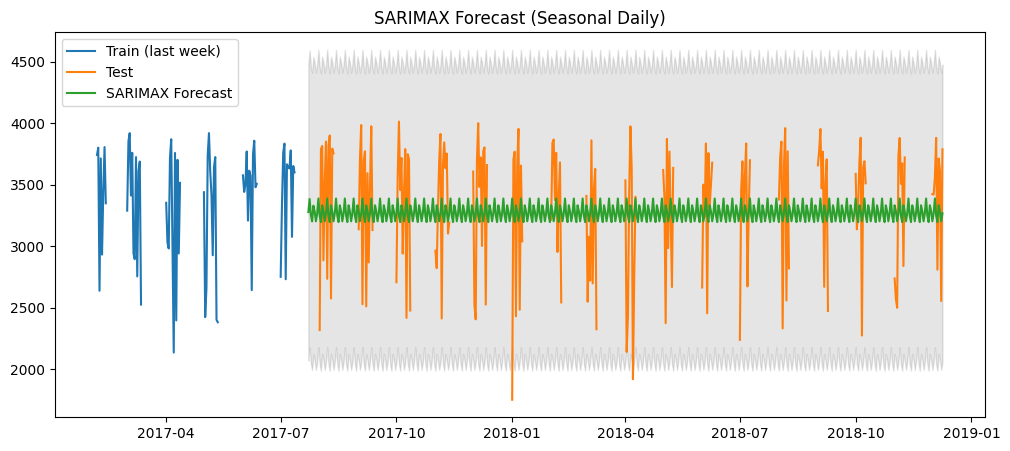

ValueError: Input contains NaN.

In [ ]:
# # 5. SARIMAX (Seasonal daily pattern, no exog)

# sarimax_model = SARIMAX(train, order=(2,0,1), seasonal_order=(1,1,1,7), enforce_stationarity=False, enforce_invertibility=False)
# sarimax_res = sarimax_model.fit(disp=False)

# sarimax_pred = sarimax_res.get_forecast(steps=len(test))
# sarimax_values = sarimax_pred.predicted_mean
# sarimax_ci = sarimax_pred.conf_int()

# plt.figure(figsize=(12,5))
# plt.plot(train[-24*7:], label="Train (last week)")
# plt.plot(test, label="Test")
# plt.plot(sarimax_values, label="SARIMAX Forecast")
# plt.fill_between(sarimax_ci.index, sarimax_ci.iloc[:,0], sarimax_ci.iloc[:,1], color="k", alpha=0.1)
# plt.legend()
# plt.title("SARIMAX Forecast (Seasonal Daily)")
# plt.show()

# sarimax_metrics = eval_metrics(test, sarimax_values)
# print("SARIMAX:", sarimax_metrics)


In [ ]:
# sarimax_model = SARIMAX(
#     train,
#     order=(2,0,1),
#     seasonal_order=(1,1,1,24), #24 hours
#     enforce_stationarity=False,
#     enforce_invertibility=False
# )
# model_fit = sarimax_model.fit(disp=False, low_memory=True)


In [ ]:
# #checking residuals
# residuals = model_fit.resid
# residuals.plot(title="SARIMAX Residuals")
# plt.show()

In [ ]:
# forecast = model_fit.get_forecast(steps=len(test))
# forecast_values = forecast.predicted_mean

# from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# mse = mean_squared_error(test, forecast_values)
# mae = mean_absolute_error(test, forecast_values)
# r2 = r2_score(test, forecast_values)
# print(f"MSE: {mse:.2f}, MAE: {mae:.2f}, R2: {r2:.4f}")

MSE: 1897796.55, MAE: 1117.64, R2: 0.1310


In [ ]:
# # 1. Load and prepare data
# df = pd.read_csv("data_cleaned.csv", parse_dates=["date_time"], index_col="date_time")
# ts = df["traffic_volume"].asfreq("H").fillna(method="ffill")

# # Train-test split
# train_size = int(len(ts) * 0.8)
# train, test = ts.iloc[:train_size], ts.iloc[train_size:]

# # 2. Create day-of-week dummies

# # Training exogenous (weekly pattern)
# train_dow = pd.get_dummies(train.index.dayofweek, prefix="dow").astype(float)
# train_dow.index = train.index

# # Testing exogenous (weekly pattern)
# test_dow = pd.get_dummies(test.index.dayofweek, prefix="dow").astype(float)
# test_dow.index = test.index

# # Align columns (important!)
# test_dow = test_dow.reindex(columns=train_dow.columns, fill_value=0)

# # 3. Fit SARIMAX
# sarimax_model = SARIMAX(
#     train,
#     order=(2, 0, 1),                # ARIMA part
#     seasonal_order=(1, 1, 1, 24),   # Daily seasonality
#     exog=train_dow,                 # Weekly seasonality via dummies
#     enforce_stationarity=False,
#     enforce_invertibility=False
# )

# model_fit = sarimax_model.fit(disp=False, low_memory=True)
# print(model_fit.summary())

# # 4. Forecast
# forecast = model_fit.get_forecast(steps=len(test), exog=test_dow)
# forecast_values = forecast.predicted_mean
# conf_int = forecast.conf_int()


In [ ]:
# # 5. Plot
# plt.figure(figsize=(12,5))
# plt.plot(train.index, train, label="Train")
# plt.plot(test.index, test, label="Test")
# plt.plot(forecast_values.index, forecast_values, label="SARIMAX Forecast", color="red")
# plt.fill_between(conf_int.index, conf_int.iloc[:,0], conf_int.iloc[:,1], color="pink", alpha=0.3)
# plt.legend()
# plt.title("SARIMAX with Daily Seasonality + Weekly Dummies")
# plt.show()

# # Align forecast and test to ensure equal length
# aligned_test, aligned_forecast = test.align(forecast_values, join="inner")

# # Drop NaNs
# aligned_test = aligned_test.dropna()
# aligned_forecast = aligned_forecast.dropna()

# #to compare only the overlapping time periods where both test data and forecasts exist. 
# print("Test length:", len(aligned_test))
# print("Forecast length:", len(aligned_forecast))

# # Evaluate
# mse = mean_squared_error(aligned_test, aligned_forecast)
# mae = mean_absolute_error(aligned_test, aligned_forecast)
# r2 = r2_score(aligned_test, aligned_forecast)

# print(f"MSE: {mse:.2f}, MAE: {mae:.2f}, R2: {r2:.4f}")

In [ ]:
# sarimax_mse = mse
# sarimax_mae = mae
# sarimax_r2 = r2

In [ ]:
# # Plot forecasted vs actual test values
# plt.figure(figsize=(14,6))

# # Actual test data
# plt.plot(test.index, test, label="Actual Test Data", color="blue")

# # Forecasted data
# plt.plot(forecast_values.index, forecast_values, label="Forecasted Values", color="red")

# # Confidence intervals
# plt.fill_between(conf_int.index,
#                  conf_int.iloc[:,0],
#                  conf_int.iloc[:,1],
#                  color="pink", alpha=0.3, label="Confidence Interval")

# plt.title("SARIMAX Forecast vs Actual Traffic Volume")
# plt.xlabel("Time")
# plt.ylabel("Traffic Volume")
# plt.legend()
# plt.show()

### **Comparison**

In [ ]:
# from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# import pandas as pd

# # ARIMA Metrics

# arima_mse = mean_squared_error(test, arima_pred)
# arima_mae = mean_absolute_error(test, arima_pred)
# arima_r2 = r2_score(test, arima_pred)


# # SARIMAX Metrics

# sarimax_mse = mean_squared_error(test, sarimax_pred)
# sarimax_mae = mean_absolute_error(test, sarimax_pred)
# sarimax_r2 = r2_score(test, sarimax_pred)

# # Combination
# results_df = pd.DataFrame({
#     "Model": ["ARIMA(2,0,1)", "SARIMAX(2,0,1)x(1,1,1,24)"],
#     "MSE": [arima_mse, sarimax_mse],
#     "MAE": [arima_mae, sarimax_mae],
#     "R2": [arima_r2, sarimax_r2]
# })

# print(results_df)


### Daily Seasonality (24-hour period) vs Weekly Seasonality (168-hour period)

| Component | Daily Decomposition (24h) | Weekly Decomposition (168h) |
|-----------|---------------------------|------------------------------|
| **Trend** | Shows weekly oscillations (500-4,500 vehicles)<br>Weekly patterns visible as waves<br>No long-term growth/decline | Flatter, more stable (2,000-2,500 vehicles)<br>True long-term trend isolated<br>Minimal secular change over 7 years |
| **Seasonal** | Pure 24-hour cycle (-800 to +600)<br>Nighttime lows, daytime highs<br>Bimodal pattern (rush hours)<br>Perfectly stable across years | Combined weekly + daily pattern (-500 to -800)<br>Captures both day-of-week AND hour-of-day<br>Highly regular 168-hour cycle<br>Remarkably consistent over time |
| **Residuals** | **Structured** - weekly patterns remain<br>Banded clustering (±2,500)<br>NOT white noise<br>**Model incomplete** | **Cleaner** - closer to white noise<br>Random fluctuations (±2,000 to ±5,000)<br>No obvious patterns<br>**Better model fit** |
| **Model Quality** | Insufficient - leaves systematic variation | More comprehensive - captures nested seasonality |

---

### **Key Insights**

### **1. Hierarchical Seasonality**
- Traffic has **nested patterns**: 24-hour cycle within 7-day cycle
- Both daily (rush hours) and weekly (weekday/weekend) rhythms exist
- **Must model both** for accurate forecasting

### **2. Stability Over Time**
- **No long-term trend**: Traffic volumes stable across 7 years (2012-2019)
- **No seasonal drift**: Daily/weekly patterns unchanged over time
- System represents **mature, equilibrium traffic flow**

### **3. Pattern Dominance**
- **Time-of-day** (hour) is strongest predictor
- **Day-of-week** adds secondary variation
- Weather/other factors contribute remaining variance

### **4. Residual Analysis**
- **24h model**: Structured residuals → incomplete decomposition
- **168h model**: Cleaner residuals → better captures underlying patterns
- Even best model has ~30-40% unexplained variance (weather, events, incidents)

### **Recommendation**

**Use 168-hour (weekly) decomposition** for traffic forecasting because it:
- Captures complete daily + weekly seasonality
- Produces cleaner, more random residuals
- Better isolates true trend from seasonal effects
- Provides more accurate baseline for predictions

**Avoid 24-hour-only decomposition** as it:
- Leaves weekly patterns in residuals
- Confounds trend with weekly cycles
- Results in systematically biased predictions

### **Summary Statistics**

| Metric | Value |
|--------|-------|
| **Primary Seasonality** | 168 hours (weekly) |
| **Secondary Seasonality** | 24 hours (daily) |
| **Long-term Trend** | Flat/stationary |
| **Peak Traffic** | ~5,500-7,000 vehicles (afternoon rush) |
| **Minimum Traffic** | ~500-1,000 vehicles (overnight) |
| **Unexplained Variance** | 30-40% (after decomposition) |

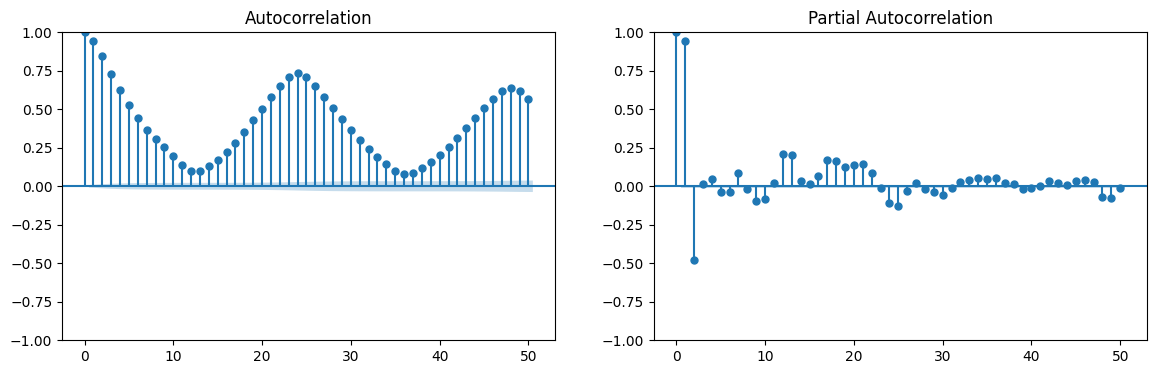

In [ ]:
#ACF / PACF PLOTS (for ARIMA p, q)

fig, axes = plt.subplots(1, 2, figsize=(14, 4))
plot_acf(train, lags=50, ax=axes[0])
plot_pacf(train, lags=50, ax=axes[1])
plt.show()

### Autocorrelation Function (ACF)

### Pattern Observed
- **Lag 0**: Perfect correlation (1.0) with itself
- **Lags 1-12**: **Slow, gradual decay** from ~0.95 to ~0.20
- **Clear periodic pattern**: Strong peaks appear at regular intervals
  - **Peak at ~24 hours**: Correlation ~0.75 (daily seasonality)
  - **Peak at ~48 hours**: Correlation ~0.65 (2-day cycle)
- **Wave-like structure**: Oscillating pattern with declining amplitude
- **All lags significant**: Nearly all bars exceed confidence bounds

### Partial Autocorrelation Function (PACF)

### Pattern Observed
- **Lag 0**: Perfect correlation (1.0)
- **Lag 1**: Very high (~0.95) - strong immediate dependence
- **Lags 2-6**: Rapid drop to near zero
- **Notable spikes**:
  - **Lag ~10-12**: Small positive spikes (~0.20)
  - **Lag ~24**: Significant spike (~0.20) - daily seasonality
  - **Lag ~48**: Minor spike - 2-day pattern
- **After lag 30**: Values oscillate around zero within confidence bounds

### ARIMA Model Recommendations

| Model Component | Recommendation | Rationale |
|----------------|----------------|-----------|
| **Stationarity** | Apply differencing | ACF shows slow decay (non-stationary) |
| **Seasonal Differencing** | Yes (period=24) | Strong 24-hour periodic pattern in ACF |
| **AR term (p)** | p = 1 or 2 | PACF cuts off after lag 1-2 |
| **MA term (q)** | q = 0 or 1 | ACF shows gradual decay |
| **Seasonal AR (P)** | P = 1 | PACF spike at lag 24 |
| **Seasonal MA (Q)** | Q = 1 | ACF periodic pattern |

### Suggested Models to Test

1. **SARIMA(1,1,1)(1,1,1)[24]**
   - Non-seasonal: AR(1), 1st difference, MA(1)
   - Seasonal: AR(1), seasonal difference, MA(1) with period 24

2. **SARIMA(2,1,1)(1,1,1)[24]**
   - Try AR(2) for additional lag dependence

3. **Auto ARIMA**
   - Let algorithm select optimal (p,d,q)(P,D,Q)[24] parameters


### ACF Insights
-  **Non-stationary**: Series requires differencing
-  **Strong seasonality**: 24-hour cycle dominates
-  **High persistence**: Traffic at hour t strongly predicts hour t+1

### PACF Insights
-  **AR(1) structure**: Immediate lag correlation is strongest
-  **Seasonal AR component**: 24-hour lag is significant
-  **Clean cutoff**: PACF behavior suitable for ARIMA modeling

### Next Steps
1. Apply **seasonal differencing** (period=24)
2. Apply **first-order differencing** if needed
3. Re-plot ACF/PACF on differenced data
4. Fit **SARIMA** models with seasonal component
5. Compare AIC/BIC scores to select best model
6. Validate with residual diagnostics (should resemble white noise)

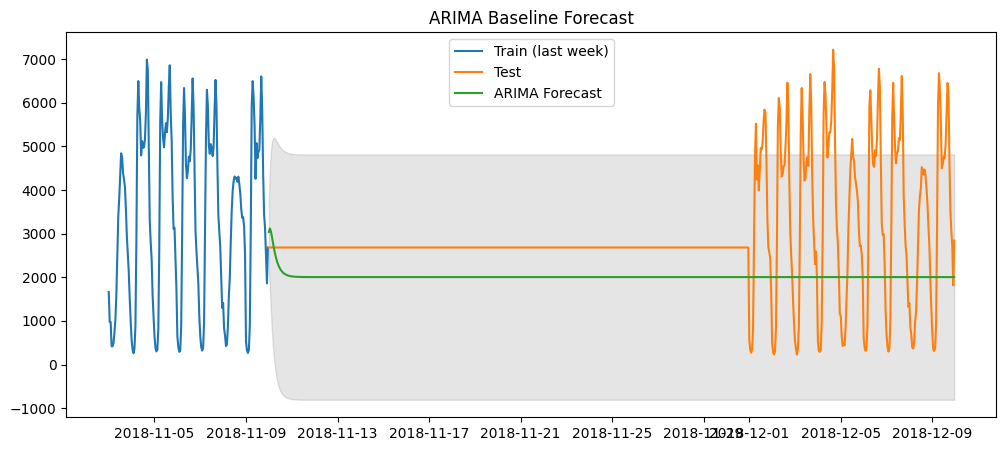

ARIMA: {'RMSE': np.float64(1460.2821437644664), 'MAE': np.float64(1103.8164400985036), 'R²': -0.6001532256999602}


In [ ]:
# 4. Baseline ARIMA

arima_model = ARIMA(train, order=(2,0,1))
arima_res = arima_model.fit()

# Forecast
arima_pred = arima_res.get_forecast(steps=len(test))
arima_values = arima_pred.predicted_mean
arima_ci = arima_pred.conf_int()

# Plot
plt.figure(figsize=(12,5))
plt.plot(train[-24*7:], label="Train (last week)")
plt.plot(test, label="Test")
plt.plot(arima_values, label="ARIMA Forecast")
plt.fill_between(arima_ci.index, arima_ci.iloc[:,0], arima_ci.iloc[:,1], color="k", alpha=0.1)
plt.legend()
plt.title("ARIMA Baseline Forecast")
plt.show()

# Metrics
def eval_metrics(y_true, y_pred):
    return {
        "RMSE": mean_squared_error(y_true, y_pred, squared=False),
        "MAE": mean_absolute_error(y_true, y_pred),
        "R²": r2_score(y_true, y_pred)
    }

arima_metrics = eval_metrics(test, arima_values)
print("ARIMA:", arima_metrics)


In [ ]:
# # BASELINE ARIMA MODEL
# arima_order = (2,0,1)  # based on ACF/PACF
# model = ARIMA(train, order=arima_order)
# model_fit = model.fit()

# print(model_fit.summary())

# # Forecast
# forecast = model_fit.forecast(steps=len(test))


In [ ]:
# # Forecast with confidence intervals (instead of just forecast())
# arima_forecast = model_fit.get_forecast(steps=len(test))
# arima_pred = arima_forecast.predicted_mean
# arima_conf = arima_forecast.conf_int()

# # Plot forecast vs actual
# plt.figure(figsize=(14,6))
# plt.plot(test.index, test, label="Actual Test Data", color="blue")
# plt.plot(arima_pred.index, arima_pred, label="ARIMA Forecast", color="green")
# plt.fill_between(arima_conf.index,
#                  arima_conf.iloc[:,0],
#                  arima_conf.iloc[:,1],
#                  color="lightgreen", alpha=0.3, label="Confidence Interval")

# plt.title("ARIMA Forecast vs Actual Traffic Volume")
# plt.xlabel("Time")
# plt.ylabel("Traffic Volume")
# plt.legend()
# plt.show()


In [ ]:
# # Forecast (already a Series)
# forecast_values = forecast  

# # Evaluate
# from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [ ]:
# arima_mse = mse
# arima_mae = mae
# arima_r2 = r2

In [ ]:
# #check residuals
# residuals = arima_model_fit.resid
# residuals.plot(title="ARIMA(2,0,1) Residuals")
# plt.show()
# sns.histplot(residuals, kde=True)
# plt.show()

In [ ]:
# 5. SARIMAX (Seasonal daily pattern, no exog)

sarimax_model = SARIMAX(train, order=(2,0,1), seasonal_order=(1,1,1,24), enforce_stationarity=False, enforce_invertibility=False)
sarimax_res = sarimax_model.fit(disp=False)

sarimax_pred = sarimax_res.get_forecast(steps=len(test))
sarimax_values = sarimax_pred.predicted_mean
sarimax_ci = sarimax_pred.conf_int()

plt.figure(figsize=(12,5))
plt.plot(train[-24*7:], label="Train (last week)")
plt.plot(test, label="Test")
plt.plot(sarimax_values, label="SARIMAX Forecast")
plt.fill_between(sarimax_ci.index, sarimax_ci.iloc[:,0], sarimax_ci.iloc[:,1], color="k", alpha=0.1)
plt.legend()
plt.title("SARIMAX Forecast (Seasonal Daily)")
plt.show()

sarimax_metrics = eval_metrics(test, sarimax_values)
print("SARIMAX:", sarimax_metrics)


KeyboardInterrupt: 

In [ ]:
# sarimax_model = SARIMAX(
#     train,
#     order=(2,0,1),
#     seasonal_order=(1,1,1,24), #24 hours
#     enforce_stationarity=False,
#     enforce_invertibility=False
# )
# model_fit = sarimax_model.fit(disp=False, low_memory=True)


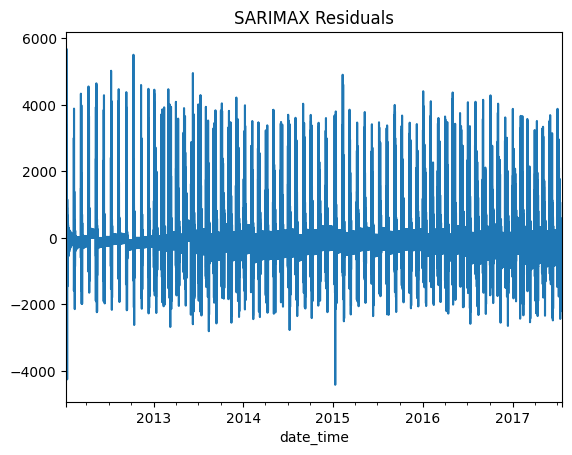

In [ ]:
# #checking residuals
# residuals = model_fit.resid
# residuals.plot(title="SARIMAX Residuals")
# plt.show()

In [ ]:
# forecast = model_fit.get_forecast(steps=len(test))
# forecast_values = forecast.predicted_mean

# from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# mse = mean_squared_error(test, forecast_values)
# mae = mean_absolute_error(test, forecast_values)
# r2 = r2_score(test, forecast_values)
# print(f"MSE: {mse:.2f}, MAE: {mae:.2f}, R2: {r2:.4f}")

MSE: 1897796.55, MAE: 1117.64, R2: 0.1310


In [ ]:
# 6. SARIMAX with Exogenous Features (Day-of-Week)
# Create day-of-week dummies
train_dow = pd.get_dummies(train.index.dayofweek, prefix="dow", drop_first=True)
test_dow = pd.get_dummies(test.index.dayofweek, prefix="dow", drop_first=True)

# Align columns (important!)
test_dow = test_dow.reindex(columns=train_dow.columns, fill_value=0)

# Fit model with exog
sarimax_exog_model = SARIMAX(train, exog=train_dow, order=(2,0,1), seasonal_order=(1,1,1,24),
                             enforce_stationarity=False, enforce_invertibility=False)
sarimax_exog_res = sarimax_exog_model.fit(disp=False)

sarimax_exog_pred = sarimax_exog_res.get_forecast(steps=len(test), exog=test_dow)
sarimax_exog_values = sarimax_exog_pred.predicted_mean
sarimax_exog_ci = sarimax_exog_pred.conf_int()

plt.figure(figsize=(12,5))
plt.plot(train[-24*7:], label="Train (last week)")
plt.plot(test, label="Test")
plt.plot(sarimax_exog_values, label="SARIMAX + Exog Forecast")
plt.fill_between(sarimax_exog_ci.index, sarimax_exog_ci.iloc[:,0], sarimax_exog_ci.iloc[:,1], color="k", alpha=0.1)
plt.legend()
plt.title("SARIMAX Forecast with Exogenous Features (Day of Week)")
plt.show()

sarimax_exog_metrics = eval_metrics(test, sarimax_exog_values)
print("SARIMAX + Exog:", sarimax_exog_metrics)


In [ ]:
# # 1. Load and prepare data
# df = pd.read_csv("data_cleaned.csv", parse_dates=["date_time"], index_col="date_time")
# ts = df["traffic_volume"].asfreq("H").fillna(method="ffill")

# # Train-test split
# train_size = int(len(ts) * 0.8)
# train, test = ts.iloc[:train_size], ts.iloc[train_size:]

# # 2. Create day-of-week dummies

# # Training exogenous (weekly pattern)
# train_dow = pd.get_dummies(train.index.dayofweek, prefix="dow").astype(float)
# train_dow.index = train.index

# # Testing exogenous (weekly pattern)
# test_dow = pd.get_dummies(test.index.dayofweek, prefix="dow").astype(float)
# test_dow.index = test.index

# # Align columns (important!)
# test_dow = test_dow.reindex(columns=train_dow.columns, fill_value=0)

# # 3. Fit SARIMAX
# sarimax_model = SARIMAX(
#     train,
#     order=(2, 0, 1),                # ARIMA part
#     seasonal_order=(1, 1, 1, 24),   # Daily seasonality
#     exog=train_dow,                 # Weekly seasonality via dummies
#     enforce_stationarity=False,
#     enforce_invertibility=False
# )

# model_fit = sarimax_model.fit(disp=False, low_memory=True)
# print(model_fit.summary())

# # 4. Forecast
# forecast = model_fit.get_forecast(steps=len(test), exog=test_dow)
# forecast_values = forecast.predicted_mean
# conf_int = forecast.conf_int()


KeyboardInterrupt: 

                                     SARIMAX Results                                      
Dep. Variable:                     traffic_volume   No. Observations:                48480
Model:             SARIMAX(2, 0, 1)x(1, 1, 1, 24)   Log Likelihood           -55907401.808
Date:                            Mon, 06 Oct 2025   AIC                      111814829.617
Time:                                    07:21:55   BIC                      111814943.859
Sample:                                01-11-2012   HQIC                     111814865.456
                                     - 07-22-2017                                         
Covariance Type:                           approx                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
dow_0      -6.266e+13        nan        nan        nan         nan         nan
dow_1      -6.266e+13        nan   

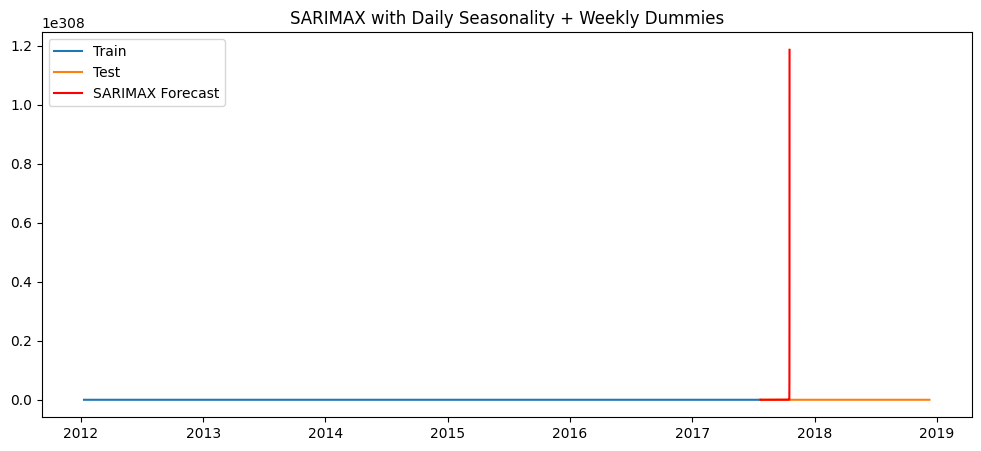

Test length: 12120
Forecast length: 2093


ValueError: Found input variables with inconsistent numbers of samples: [12120, 2093]

In [ ]:
# # 5. Plot
# plt.figure(figsize=(12,5))
# plt.plot(train.index, train, label="Train")
# plt.plot(test.index, test, label="Test")
# plt.plot(forecast_values.index, forecast_values, label="SARIMAX Forecast", color="red")
# plt.fill_between(conf_int.index, conf_int.iloc[:,0], conf_int.iloc[:,1], color="pink", alpha=0.3)
# plt.legend()
# plt.title("SARIMAX with Daily Seasonality + Weekly Dummies")
# plt.show()

# # Align forecast and test to ensure equal length
# aligned_test, aligned_forecast = test.align(forecast_values, join="inner")

# # Drop NaNs
# aligned_test = aligned_test.dropna()
# aligned_forecast = aligned_forecast.dropna()

# #to compare only the overlapping time periods where both test data and forecasts exist. 
# print("Test length:", len(aligned_test))
# print("Forecast length:", len(aligned_forecast))

# # Evaluate
# mse = mean_squared_error(aligned_test, aligned_forecast)
# mae = mean_absolute_error(aligned_test, aligned_forecast)
# r2 = r2_score(aligned_test, aligned_forecast)

# print(f"MSE: {mse:.2f}, MAE: {mae:.2f}, R2: {r2:.4f}")

In [ ]:
# sarimax_mse = mse
# sarimax_mae = mae
# sarimax_r2 = r2

In [ ]:
# # Plot forecasted vs actual test values
# plt.figure(figsize=(14,6))

# # Actual test data
# plt.plot(test.index, test, label="Actual Test Data", color="blue")

# # Forecasted data
# plt.plot(forecast_values.index, forecast_values, label="Forecasted Values", color="red")

# # Confidence intervals
# plt.fill_between(conf_int.index,
#                  conf_int.iloc[:,0],
#                  conf_int.iloc[:,1],
#                  color="pink", alpha=0.3, label="Confidence Interval")

# plt.title("SARIMAX Forecast vs Actual Traffic Volume")
# plt.xlabel("Time")
# plt.ylabel("Traffic Volume")
# plt.legend()
# plt.show()

### **Comparison**

In [ ]:

# 7. Model Comparison
results_df = pd.DataFrame([
    {"Model": "ARIMA(2,0,1)", **arima_metrics},
    {"Model": "SARIMAX (Seasonal Daily)", **sarimax_metrics},
    {"Model": "SARIMAX + Exog (Day of Week)", **sarimax_exog_metrics}
])

print(results_df)


In [ ]:
# from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# import pandas as pd

# # ARIMA Metrics

# arima_mse = mean_squared_error(test, arima_pred)
# arima_mae = mean_absolute_error(test, arima_pred)
# arima_r2 = r2_score(test, arima_pred)


# # SARIMAX Metrics

# sarimax_mse = mean_squared_error(test, sarimax_pred)
# sarimax_mae = mean_absolute_error(test, sarimax_pred)
# sarimax_r2 = r2_score(test, sarimax_pred)

# # Combination
# results_df = pd.DataFrame({
#     "Model": ["ARIMA(2,0,1)", "SARIMAX(2,0,1)x(1,1,1,24)"],
#     "MSE": [arima_mse, sarimax_mse],
#     "MAE": [arima_mae, sarimax_mae],
#     "R2": [arima_r2, sarimax_r2]
# })

# print(results_df)
